In [17]:
import os
import sys

current_dir =  os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import pyro
from collab import foraging_toolkit as ft
import torch.nn.functional as F
import logging
import time

import plotly.io as pio
from plotly import express as px, graph_objects as go, figure_factory as ff
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import (
    AutoNormal,
    AutoDiagonalNormal,
    AutoMultivariateNormal,
    init_to_mean,
    init_to_value,
)


from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from pyro.optim import Adam
import pyro.optim as optim
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS


In [18]:
ducks_raw = pd.read_csv('../data/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv')
sparrows_raw = pd.read_csv('../data/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv')

display(ducks_raw.head())
display(sparrows_raw.head())

print(ducks_raw.shape)
print(sparrows_raw.shape)

,x,y,time,bird
0,84.853396,22.812170,0,1
1,308.485824,22.659691,0,2
2,75.273170,91.047143,0,12
3,68.939135,99.259521,0,17
4,155.181453,109.061447,0,20


,x,y,time,bird
0,294.843352,82.777842,0,2
1,110.659049,86.254356,0,3
2,6.545799,136.260651,0,11
3,294.693470,83.130834,1,2
4,110.614951,86.297426,1,3


(8867, 4)
(22821, 4)


In [19]:
ducks_sub = ft.subsample_frames_evenly_spaced(ducks_raw)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)

sps_sub = ft.subsample_frames_evenly_spaced(sparrows_raw)
sps_sub = ft.rescale_to_grid(sps_sub, 90)

original_frames: 1450
original_shape: (8867, 4)
resulting_frames: 300
resulting_shape: (1858, 4)
min_time 1
max_time 300
original_frames: 11549
original_shape: (22821, 4)
resulting_frames: 300
resulting_shape: (617, 4)
min_time 1
max_time 300


In [25]:
def cp_birds_to_bird_distances(birds, birdsDF):
    
    distances = [ ]

    for bird in range(len(birds)):
        
        bird_distances = []
        
        times_b = birds[bird]["time"].unique()

        for frame in times_b:

            #frame_index = np.where(times_b == frame)[0][0]
            
            birds_at_frameDF = birdsDF[birdsDF['time'] == frame]
            birds_at_frameDF.sort_values(by="bird", inplace=True)
            #birds_at_frame = [group for _, group in birds_at_frameDF.groupby("bird")]
            
            birds_at_frame = birds_at_frameDF['bird'].unique()
            birds_at_frame.sort()

            bird_x = birds[bird][birds[bird]["time"] == frame]["x"].item()
            
            bird_y = birds[bird][birds[bird]["time"] == frame]["y"].item()
             
            distances_now  = []      
            for other in birds_at_frame:
                
                other_x = birds[other][birds[other]["time"] == frame]["x"].item()
                other_y = birds[other][birds[other]["time"] == frame]["y"].item()
            
                distances_now.append(math.sqrt((bird_x - other_x) ** 2 + (bird_y - other_y) ** 2))
                
            assert len(distances_now) == len(birds_at_frame)
  
            distances_now_df = pd.DataFrame(birds_at_frame, distances_now)
            
        bird_distances.append(distances_now_df)    
            
    distances.append(bird_distances)    
                                
    return(distances)


#let's get a feel for the distance distribution of ducks
duck_slices = ft.sample_time_slices(ducks_sub, 1)
duck_slices_grouped = [group for _, group in duck_slices.groupby("bird")]

duck_distances = cp_birds_to_bird_distances(duck_slices_grouped, duck_slices)


TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [26]:
def distances_and_peaks(distances, bins=40, x_min=None, x_max=None):
    distances_list = concat(distances)
    
    # distances_list = distancesDF.values.ravel().tolist()
    # distances_list = list(filter(lambda x: x != 0, distances_list))
    # hist, bins, _ = plt.hist(distances_list, bins=40, color="blue", edgecolor="black")
    # peaks, _ = find_peaks(hist)

    # plt.hist(distances_list, bins=bins, color="blue", edgecolor="black")
    # plt.scatter(bins[peaks], hist[peaks], c="red", marker="o", s=50, label="Peaks")

    # peak_values = hist[peaks]
    # peak_positions = np.round(bins[peaks], 2)

    # if x_min is not None:
    #     plt.xlim(x_min, x_max)

    # for i, peak_x in enumerate(bins[peaks]):
    #     plt.annotate(
    #         f"{peak_positions[i]}",
    #         (peak_x, hist[peaks][i]),
    #         textcoords="offset points",
    #         xytext=(0, 10),
    #         ha="center",
    #         fontsize=10,
    #         color="red",
    #     )


distances_and_peaks(duck_distances)


NameError: name 'concat' is not defined

In [20]:
print(duck_distances[0][2])


[[ 0.         43.56604182 45.18849411 30.88689042 44.94441011 69.05070601
  32.89376841 45.         14.2126704  62.36184731]]


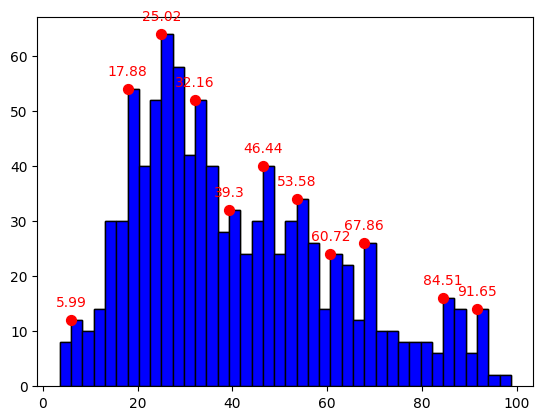

In [ ]:
# now sparrows et al.

sps_slices = ft.sample_time_slices(sps_sub, 1)
sps_distances = ft.birds_to_bird_distances(sps_slices, joint_df = True)
ft.distances_and_peaks(sps_distances)

In [ ]:

ducks_obj = ft.object_from_data(ducks_sub, grid_size=90, frames=300)


In [ ]:
def cp_generate_visibility(
    birds,
    getting_worse=1.5,
    optimal=4,
    proximity_decay=1,
    time_shift=0,
    grid_size=90,
    joint_df=False,
    grid = None,
    visibility_range = 90,
):  
    if grid is None:
        grid = ft.generate_grid(grid_size)
    else:
        grid = grid.copy()

    visibility =  [] 
    
   # bird_distances = ft.birds_to_bird_distances(birds, joint_df)

    for bird in range(len(birds)):
        ranges = [] 
        times_b = birds[bird]['time'].unique()
        for frame in times_b:
            g = grid.copy()
            
            
            temporary_x = birds[bird]['x'][birds[bird]['time'] == frame]
            temporary_y = birds[bird]['y'][birds[bird]['time'] == frame]
            
        
            
            g["distance"] = (
                (g["x"] - temporary_x.item()) * 2 + (g["y"] - temporary_y.item()) * 2
                ) ** 0.5
          
            
            range_df = g[g["distance"] <= visibility_range].copy()
            range_df = g[g["distance"] <= visibility_range].copy()
            range_df["distance_x"] = abs(range_df["x"] - temporary_x.item())
            range_df["distance_y"] = abs(range_df["y"] - temporary_y.item())
            range_df["visibility"] = range_df["distance"].apply(lambda d: ft.visibility_vs_distance(d, visibility_range))
            range_df["bird"] = bird + 1
            range_df["time"] = frame
            
            range_df["time"] = range_df["time"] + time_shift
            ranges.append(range_df)
            
        visibility.append(ranges)
        
    birds_visibilities = []
    for bird in range(len(birds)):
        birds_visibilities.append(pd.concat(visibility[bird]))

    visibility_df = pd.concat(birds_visibilities)    
            
    return {"visibility": visibility, "visibilityDF": visibility_df}

ducks_vis = cp_generate_visibility(ducks_obj.birds)

ducks_obj.visibility = ducks_vis["visibility"]
ducks_obj.visibilityDF = ducks_vis["visibilityDF"]


In [ ]:
ducks_obj.birdsDF['bird'].min()

1

In [ ]:
display(ducks_obj.visibility[0][1])

,x,y,distance,distance_x,distance_y,visibility,bird,time
179,2,90,0.000000,71.0,71.0,1.000000,1,117
268,3,89,0.000000,70.0,70.0,1.000000,1,117
269,3,90,1.414214,70.0,71.0,0.999695,1,117
357,4,88,0.000000,69.0,69.0,1.000000,1,117
358,4,89,1.414214,69.0,70.0,0.999695,1,117
...,...,...,...,...,...,...,...,...
8095,90,86,12.961481,17.0,67.0,0.974521,1,117
8096,90,87,13.038405,17.0,68.0,0.974219,1,117
8097,90,88,13.114877,17.0,69.0,0.973917,1,117
8098,90,89,13.190906,17.0,70.0,0.973615,1,117


In [ ]:
display(
ducks_obj.birdsDF[ducks_obj.birdsDF['bird'] == 1]
)

,x,y,time,bird
4449,72.0,19.0,116,1
4499,73.0,19.0,117,1
4549,73.0,19.0,118,1
4589,73.0,19.0,119,1
4639,73.0,19.0,120,1
4689,74.0,20.0,121,1
4739,74.0,20.0,122,1
4789,74.0,20.0,123,1
4839,74.0,20.0,124,1
4879,74.0,21.0,125,1


In [ ]:
def cp_generate_proximity_score(
    birds, birdsDF,
    visibility,
    visibility_range = 100,
    getting_worse=1.5,
    optimal=4,
    proximity_decay=1,
    start=0,
    end=None,
    time_shift=0,
    joint_df=False,
):
    if end is None:
        end = len(birds[0])

    bird_distances = ft.birds_to_bird_distances(birds, joint_df)
    print(len(birds))
    print(len(bird_distances))

    proximity = visibility.copy()
    
    

    for bird in range(len(birds)):
        
        times_b = birds[bird]['time'].unique() 
        
        for frame in times_b:
            frame_index = np.where(times_b == frame)[0][0]
            
            birds_at_frameDF = birdsDF[birdsDF['time'] == frame]
            birds_at_frameDF.sort_values(by="bird", inplace=True)
            #birds_at_frame = [group for _, group in birds_at_frameDF.groupby("bird")]
            
            birds_at_frame = birds_at_frameDF['bird'].unique()
            birds_at_frame.sort() # perhaps redundant
            #birds_at_frame_codes = birds_at_frame_codes.tolist()
            
            #bird_code = np.where(birds_at_frame_codes == bird)[0][0] 
            
            assert bird+1 in birds_at_frame
            
            proximity[bird][frame_index]['proximity'] = 0
            
            # dist_t = bird_distances[frame_index]
            
            # print("dist_tb", dist_t.iloc[bird + 1])
#            distbt = bird_distances[bird].iloc[frame].drop(bird + 1)
 #           print("distbt", distbt)
            
            #visible_birds = dist_tb[dist_tb <= visibility_range].index.tolist()
            #print("visible birds", visible_birds)

            #print("visible birds", visible_birds)
        # print("len vb", len(visible_birds))

        # if len(visible_birds) > 0:
        #     for vb in range(len(visible_birds)):
        #         o_x = birds[visible_birds[vb] - 1]["x"].iloc[frame]
        #         o_y = birds[visible_birds[vb] - 1]["y"].iloc[frame]

                # proximity[bird][frame]["proximity"] += [
                #     ft.proximity_score(s, getting_worse, optimal, proximity_decay)
                #     for s in np.sqrt((proximity[bird][frame]["x"] - o_x) ** 2 + (proximity[bird][frame]["y"] - o_y) ** 2)
                # ]

    #         proximity[b][t]["proximity_standardized"] = (
    #             proximity[b][t]["proximity"] - proximity[b][t]["proximity"].mean()
    #         ) / proximity[b][t]["proximity"].std()

    #         proximity[b][t]["proximity_standardized"].fillna(0, inplace=True)

    #         proximity[b][t]["bird"] = b + 1
    #         proximity[b][t]["time"] = t + 1 + time_shift

    # proximityDF = pd.concat([pd.concat(p) for p in proximity])

    # return {"proximity": proximity, "proximityDF": proximityDF}




prox = cp_generate_proximity_score(
        ducks_obj.birds, ducks_obj.birdsDF,
        ducks_obj.visibility,
        visibility_range=100,
        getting_worse=2,
        optimal=12,
        proximity_decay=.4,
        time_shift=0,
    )

29
300


In [ ]:

    
    #proximity  = np.zeros((b, t))
    
#    for b in range(len(birds)):
#        print(birds[b]['time'])
        
        #for t in birds[b]['time'].unique():
        #    print(t)
            #g = ft.generate_grid(grid_size)
                
#            print(bird_distances[t].iloc[b])
        
    
    # for b in range(len(birds)):
    #     for t in birds[b]['time'].unique():
    #          distbt = bird_distances[b].iloc[t].drop(b + 1)
    #          print(distbt)

            
            #proximity[b][t]["proximity"] = 0

    #        
          
          
    #             for vb in range(len(visible_birds)):
    #                 o_x = birds[visible_birds[vb] - 1]["x"].iloc[t]
    #                 o_y = birds[visible_birds[vb] - 1]["y"].iloc[t]

    #                 proximity[b][t]["proximity"] += [
    #                     proximity_score(s, getting_worse, optimal, proximity_decay)
    #                     for s in np.sqrt((proximity[b][t]["x"] - o_x) ** 2 + (proximity[b][t]["y"] - o_y) ** 2)
    #                 ]


    #         proximity[b][t]["proximity_standardized"] = (
    #             proximity[b][t]["proximity"] - proximity[b][t]["proximity"].mean()
    #         ) / proximity[b][t]["proximity"].std()

    #         proximity[b][t]["proximity_standardized"].fillna(0, inplace=True)

    #         proximity[b][t]["bird"] = b + 1
    #         proximity[b][t]["time"] = t + 1 + time_shift

    # proximityDF = pd.concat([pd.concat(p) for p in proximity])

    # return {"proximity": proximity, "proximityDF": proximityDF}




In [ ]:
 prox = ft.generate_proximity_score(
        sim.birds,
        sim.visibility,
        visibility_range=visibility_range,
        getting_worse=getting_worse,
        optimal=optimal,
        proximity_decay=proximity_decay,
        time_shift=time_shift,
    )
    sim.getting_worse = getting_worse
    sim.optimal = optimal
    sim.proximity_decay = proximity_decay

    sim.proximity = prox["proximity"]
    sim.proximityDF = prox["proximityDF"]
    derivation_logger.info("proximity done")

IndentationError: unexpected indent (4080439015.py, line 10)

In [ ]:
def derive_predictors(
    sim,
    rewards_decay=0.5,
    visibility_range=10,
    getting_worse=1.5,
    optimal=4,
    proximity_decay=1,
    generate_communicates=True,
    generate_trace=True,
    info_time_decay=3,
    info_spatial_decay=0.15,
    finders_tolerance=2,
    time_shift=0,
    sampling_rate=1,
    random_seed=42,
    restrict_to_invisible=True,
    dropna=True,
):
    sim.restrict_to_invisible = restrict_to_invisible

    grid = ft.generate_grid(sim.grid_size)

    grid = grid.sample(frac=sampling_rate, random_state=random_seed)

    sim.grid = grid

    if generate_trace:
        tr = ft.rewards_to_trace(
            sim.rewards,
            sim.grid_size,
            sim.num_frames,
            rewards_decay,
            time_shift=time_shift,
            grid=grid,
        )

        sim.traces = tr["traces"]
        sim.tracesDF = tr["tracesDF"]
        derivation_logger.info("traces done")

    vis = ft.construct_visibility(
        sim.birds,
        sim.grid_size,
        visibility_range=visibility_range,
        time_shift=time_shift,
        grid=grid,
    )
    
    # sim.visibility_range = visibility_range
    # sim.visibility = vis["visibility"]
    # sim.visibilityDF = vis["visibilityDF"]
    # derivation_logger.info("visibility done")

    # prox = ft.generate_proximity_score(
    #     sim.birds,
    #     sim.visibility,
    #     visibility_range=visibility_range,
    #     getting_worse=getting_worse,
    #     optimal=optimal,
    #     proximity_decay=proximity_decay,
    #     time_shift=time_shift,
    # )
    # sim.getting_worse = getting_worse
    # sim.optimal = optimal
    # sim.proximity_decay = proximity_decay

    # sim.proximity = prox["proximity"]
    # sim.proximityDF = prox["proximityDF"]
    # derivation_logger.info("proximity done")

    # ft.add_how_far_squared_scaled(sim)
    # derivation_logger.info("how_far done")

    # if generate_trace:
    #     sim.derivedDF = (
    #         sim.tracesDF.merge(sim.visibilityDF, how="inner")
    #         .merge(sim.proximityDF, how="inner")
    #         .merge(sim.how_farDF, how="inner")
    #     )
    # else:
    #     sim.derivedDF = sim.visibilityDF.merge(sim.proximityDF, how="inner").merge(sim.how_farDF, how="inner")

    # if generate_communicates:
    #     derivation_logger.info("starting to generate communicates")
    #     com = ft.generate_communicates(
    #         sim,
    #         info_time_decay,
    #         info_spatial_decay,
    #         finders_tolerance=finders_tolerance,
    #         time_shift=time_shift,
    #         grid=grid,
    #         restrict_to_invisible=sim.restrict_to_invisible,
    #     )
    #     sim.communicates = com["communicates"]
    #     sim.communicatesDF = com["communicatesDF"]

    #     sim.derivedDF = sim.derivedDF.merge(sim.communicatesDF, how="left")

    #     sim.derivedDF["communicate"].fillna(0, inplace=True)

    #     derivation_logger.info("derivedDF done")

    # pd.set_option("mode.chained_assignment", None)

    # if generate_trace:
    #     sim.rewardsDF.loc[:, "time"] = sim.rewardsDF["time"] - time_shift
    #     sim.tracesDF.loc[:, "time"] = sim.tracesDF["time"] - time_shift

    # if generate_communicates:
    #     sim.communicatesDF.loc[:, "time"] = sim.communicatesDF["time"] - time_shift

    # sim.birdsDF.loc[:, "time"] = sim.birdsDF["time"] - time_shift
    # sim.visibilityDF.loc[:, "time"] = sim.visibilityDF["time"] - time_shift
    # sim.proximityDF.loc[:, "time"] = sim.proximityDF["time"] - time_shift
    # sim.how_farDF.loc[:, "time"] = sim.how_farDF["time"] - time_shift
    # sim.derivedDF.loc[:, "time"] = sim.derivedDF["time"] - time_shift

    # if dropna:
    #     sim.derivedDF.dropna(inplace=True)

    return sim


ducs_der = derive_predictors(ducks_obj, visibility_range= 90, 
                                getting_worse = 5, optimal = 12.3, 
                                generate_communicates= False,
                                generate_trace = False)


IndexError: single positional indexer is out-of-bounds